# Exploratory Spatial Data Analysis of Disaster-Tweets

With this notebook, you can analyse tweets that were posted in the same area and on the same day as the Napa earthquake in 2014 (see https://en.wikipedia.org/wiki/2014_South_Napa_earthquake for details).  

### Assignment

Create a new markdown cell to answer the following questions:

* How many tweets are in the dataset?
* What words are the most frequent words in the wordcloud (related to the size of the words)?
* Perform  topic modelling with and without preprocessing. What could you observe?
* Which topics could you identify in the datasets? Can you label some of the topics?
* What is the min and max date of the dataset?
* How does the time-series of the disaster-related topic and the overall dataset differ?
* How does the heatmap of the disaster-related topic and the overall dataset differ?

When you are answered the questions, download your notebook as html-file and check if it worked.
File -> Download as -> HTML

Hint: You do not have to program somehting by yourself, but you have to understand the code (change some variables) and look for the answers of the questions.


## Load dataset and libraries

In [1]:
%matplotlib inline

In [21]:
from preprocessing import *
import gensim
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from gensim import corpora
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium
import pyLDAvis.gensim
import statistics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [22]:
df = pd.read_csv('../tweets/napa_tweets.csv', sep=',', error_bad_lines=False, index_col=False, warn_bad_lines=False)
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.head(5)

id              time                                  tweet_text  \
0   0  24.08.2014 23:07                             SMITE vs LOL ??   
1   1  24.08.2014 23:12  Random people complimenting you is so nice   
2   2  24.08.2014 23:37                  Calum is being an annoying   
3   3  24.08.2014 23:38                                      Plan B   
4   4  24.08.2014 23:42                              Laaawwwwllllll   

    latitude   longitude  
0  37.600700 -122.014820  
1  38.417359 -122.709612  
2  37.353794 -121.863898  
3  37.957866 -122.032392  
4  38.338400 -122.685784

In [23]:
df.shape

(90907, 5)

## Natural language processing

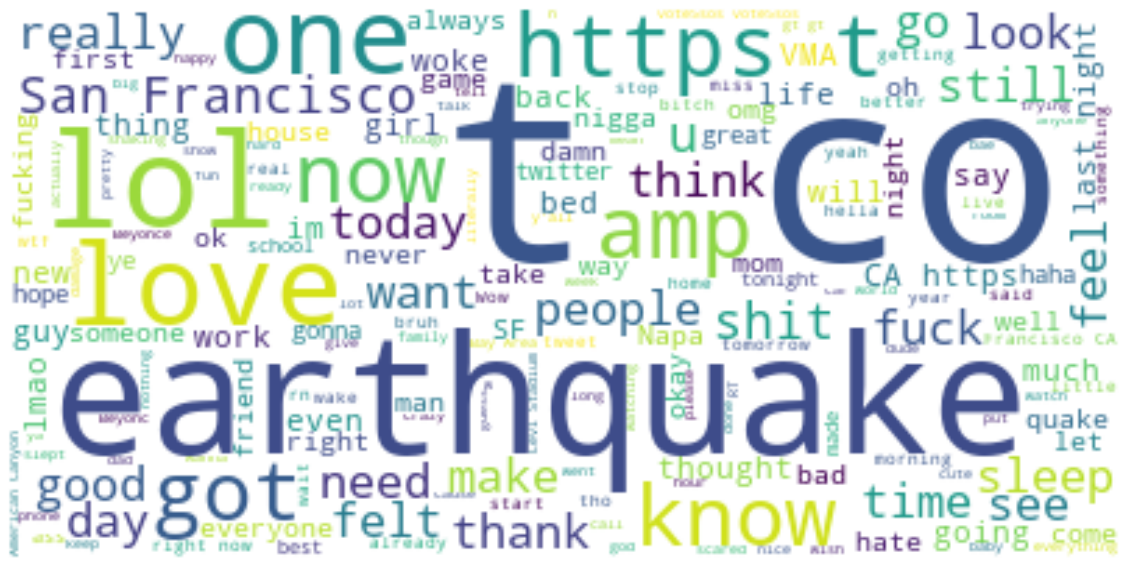

In [5]:
wordcloud = WordCloud(background_color='white').generate(' '.join(df['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Download nltk Ressources.

In [40]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter-b1066706/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/jupyter-b1066706/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Transform tweets text into usable format

In [41]:
#tweets' text as list
tweets_text = df['tweet_text'].tolist()
#lowercase
tweets_text=[tweet.lower() for tweet in tweets_text]

#remove URLs
remove_url_regex = r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b'
tweets_text = filter_tweets_before_tokenization(tweets_text, remove_url_regex)

#tokenization
tweets_text=[nltk.word_tokenize(tweet) for tweet in tweets_text]

### Text preprocessing

Test multiple preprocessing procedures and observe their impact on the analysis results

In [42]:
#remove special characters
remove_sc_regex = r'[^A-Za-z ]+'
tweets_text = filter_tweets_after_tokenization(tweets_text, remove_sc_regex)

# remove short words
remove_short_words_regex = r'\W*\b\w{1,3}\b'
tweets_text = filter_tweets_after_tokenization(tweets_text, remove_short_words_regex)

# Remove all user names in the tweet text
user_names_regex = r"@\S+"
tweets_text = filter_tweets_after_tokenization(tweets_text,user_names_regex)

#increase keyword frequency by aggregating similar keywords
# check the order if preprocessing routine! e.g. stemming would effect the performance of synonym handling
#disaster = 'hurrican'
#disaster_terms = ['hurricane', 'hurricaneharvey', 'hurricane_harvey', 'flood', 'storm']
#tweets_text = synonym_handling(tweets_text, disaster, disaster_terms)

#Remove unique words that appear only once in the dataset
frequency = getFrequency(tweets_text)
min_frequency_words = 2
tweets_text = [[token for token in tweet if frequency[token] > min_frequency_words] for tweet in tweets_text]

# Remove stop words
# You need to download the stopwords
from nltk.corpus import PlaintextCorpusReader
stoplist = set(stopwords.words('english'))
tweets_text = [[word for word in document if word not in stoplist] for document in tweets_text]

#Stemming
stemmer = PorterStemmer()
#stemmer = SnowballStemmer("english")
tweets_text = [[stemmer.stem(word) for word in sub_list] for sub_list in tweets_text]

#remove empty strings
tweets_text = [[word for word in document if word] for document in tweets_text]

tweets_text[:10]

[[],
 ['random', 'peopl', 'nice'],
 ['calum', 'annoy'],
 ['plan'],
 [],
 [],
 ['earthquak'],
 [],
 ['time'],
 []]

Create corpus and dictionary for LDA

In [43]:
dict = gensim.corpora.Dictionary(tweets_text)
corpus = [dict.doc2bow(text) for text in tweets_text]

Train Model

In [44]:
num_topics= 10
alpha = 0.0001
eta= 0.0001
passes = 10
lda = gensim.models.LdaMulticore(corpus, id2word=dict, num_topics= num_topics, alpha = alpha, eta= eta, passes = passes)

Show top words of topics

In [45]:
top_words = 5

#show top words of topics
for t in range(lda.num_topics):
    print('topic {}: '.format(t+1) + ', '.join([v[0] for v in lda.show_topic(t, top_words)]))

#show top words of topics with probabilities  
#for t in range(lda.num_topics):
#   print('topic {}: '.format(t+1) + ', '.join([v[0] + " (" + str(v[1]) + ")" for v in lda.show_topic(t, top_words)]))


topic 1: like, beyonc, fuck, life, make
topic 2: look, know, want, like, need
topic 3: peopl, hate, tweet, twitter, follow
topic 4: love, voteso, bruh, open, shit
topic 5: happi, great, sunday, birthday, work
topic 6: school, tomorrow, vma, miss, start
topic 7: back, sleep, lmao, watch, home
topic 8: napa, francisco, earthquak, thank, california
topic 9: earthquak, well, okay, everyon, hope
topic 10: earthquak, night, last, first, wait


### Visualise topics and check relation between them
If the window is not big enough, you can enlarge it with Cell -> Current Outputs -> Toggle Scrolling 

In [46]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dict, sort_topics=False)
pyLDAvis.display(vis)

Identify disaster-related topic and classify tweets accordingly

In [47]:
document_topic_list = list(lda.get_document_topics(corpus))
classified_tweets =[max(document, key=lambda x: x[1]) for document in document_topic_list]
topics = [top_prob[0]+1 for top_prob in classified_tweets]
probabilites = [top_prob[1] for top_prob in classified_tweets]
df['topics'] = topics
df['probabilities'] = probabilites

Check classified tweets

In [48]:
topic_number = 6
df.loc[df['topics'] == topic_number].head(10)

id              time                                         tweet_text  \
2      2  24.08.2014 23:37                         Calum is being an annoying   
18    18  24.08.2014 09:42  Anxiety gets the best of me &amp; it fucking s...   
55    55  24.08.2014 15:52                                   Matt got mad  So   
73    73  24.08.2014 18:13                                     Busy day today   
76    76  24.08.2014 18:26                              @supkittyhey stop????   
82    82  24.08.2014 18:54                              Man I feel good today   
97    97  24.08.2014 20:37                                     Tickle my chin   
111  111  24.08.2014 21:50                                  god i am starving   
112  112  24.08.2014 21:54                                            Done ??   
116  116  24.08.2014 22:12                              Jk. I just suck at it   

      latitude   longitude  topics  probabilities  
2    37.353794 -121.863898       6       0.499897  
18   37.330458 -121.789968       6       0.470042  
55   37.309451 -121.928295       6       0.999101  
73   38.014382 -121.303896       6       0.999550  
76   37.234910 -121.798291       6       0.999101  
82   37.790781 -121.982334       6       0.532123  
97   38.666497 -121.084509       6       0.999100  
111  38.617155 -121.425067       6       0.999101  
112  37.752806 -122.165463       6       0.999101  
116  37.480880 -122.224038       6       0.999101

## Check time-series

In [50]:
df['time'] = pd.to_datetime(df['time'])

In [51]:
print(min(df['time']))
print(max(df['time']))

2014-08-24 07:00:00
2014-08-25 06:59:00


Text(0, 0.5, '#Tweets')

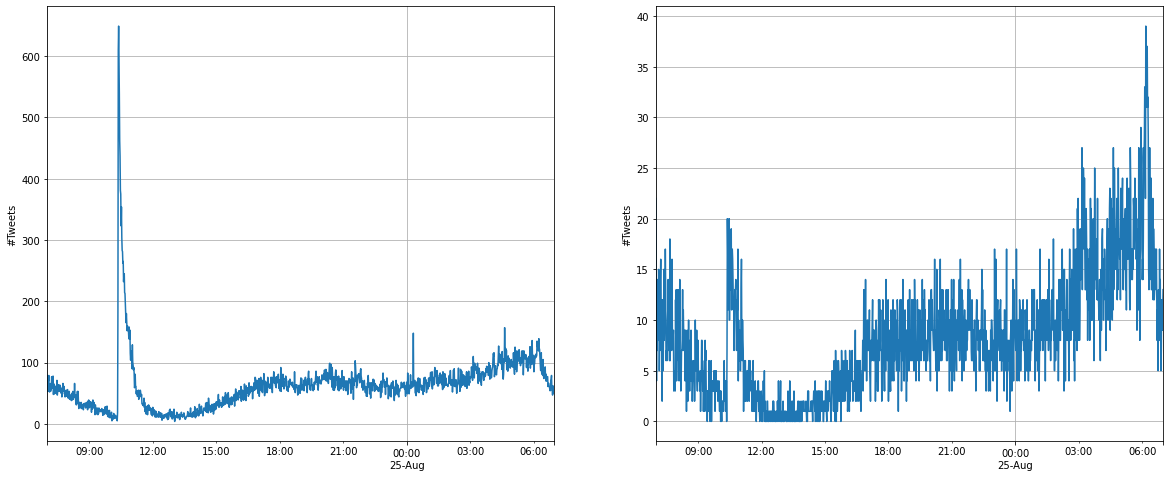

In [17]:
topic_number = 8
figure, axes = plt.subplots(1, 2,figsize=(20,8))

df_sum = df['time'].value_counts().resample('T').sum()
ax = df_sum.plot(label='Number of Tweets',ax=axes[0])
axes[0].grid()
axes[0].set_ylabel("#Tweets")

df_topic = df.loc[df['topics'] == topic_number]
df_sum = df_topic['time'].value_counts().resample('T').sum()
ax = df_sum.plot(label='Number of Tweets',ax=axes[1])
axes[1].grid()
axes[1].set_ylabel("#Tweets")

## Check geospatial distribution

In [18]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [19]:
y = statistics.mean(df['latitude']) 
x = statistics.mean(df['longitude']) 

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

df['count'] = 1
base_map = generateBaseMap([y,x],8)
HeatMap(data=df[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
display(base_map)

In [21]:
topic_numbers = [4,8]
base_maps = []
for topic_number in topic_numbers:
    df_topic = df.loc[df['topics'] == topic_number]
    base_map = generateBaseMap([y,x],8)
    HeatMap(data=df_topic[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
    base_maps.append(base_map)

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(base_maps[0].get_root().render().replace('"', '&quot;'),500,500,
                   base_maps[1].get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


More information

* [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
* [Combining machine-learning topic models and spatiotemporal analysis of social media data for disaster footprint and damage assessment](https://www.tandfonline.com/doi/full/10.1080/15230406.2017.1356242)
* [Gensim](https://radimrehurek.com/gensim/)

# Classify Tweet sentiments

Finally, let us use a state-of-the-art artificial intelligence sentiment classification method, called a RoBERTa. RoBERTA stands for Robustly Optimized BERT Pretraining Approach and can be used for different natural language processing tasks.

Orignal paper: https://arxiv.org/abs/1907.11692

Code source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment


## Load the model
Run the code below

In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [2]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [3]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

### Preprocessing the data

In [5]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

## Test the model

In [6]:
text = "Good night 😊"
text = preprocess(text)

In [8]:
def get_sentiment(text, printing = True):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    sentiment = 'positive'
    if scores[0] == max(scores):
        sentiment = 'negative'
    if scores[1] == max(scores):
        sentiment = 'neutral'
        
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    if printing == True:
        for i in range(scores.shape[0]):
            l = labels[ranking[i]]
            s = scores[ranking[i]]
            print(f"{i+1}) {l} {np.round(float(s), 4)}")
    return sentiment

In [9]:
get_sentiment(text)

1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


'positive'

#### Also try your own text .


In [12]:
text = "Twitter is the best social network! @"
text = preprocess(text)
get_sentiment(text)

1) positive 0.9875
2) neutral 0.0113
3) negative 0.0012


'positive'

In [13]:
text = "The most retweeted tweets are boring!"
text = preprocess(text)
get_sentiment(text)

1) negative 0.6886
2) neutral 0.241
3) positive 0.0705


'negative'

In [18]:
text = "The football game last night was fire!"
text = preprocess(text)
get_sentiment(text)

1) positive 0.9611
2) neutral 0.0361
3) negative 0.0028


'positive'

## Classify the sentiment for a random sample of size 10000 

In [52]:
df_sent = df.sample(100)
df_sent['sentiment'] = 'no_sentiment'

In [34]:
df_sent = df.sample(10000)
df_sent['sentiment'] = 'no_sentiment'

In [53]:
import time
start = time.time()
counter = 0
for index, row in df_sent.iterrows():
    text = row['tweet_text']
    
    ###### get the sentiment for each text
    # Hint: You might want to set printing = False, in the get_sentiment input 
    
    ### START CODE HERE ### (≈ 1 line of code) 
    sentiment = get_sentiment(preprocess(text),printing=False)
    ### END CODE HERE ### 
    
    
    
    ###### add the sentiment of each tweet to the dataframe 
    # Hint: You should use the index of each row!
    
    ### START CODE HERE ### (≈ 1 line of code)
    df_sent.loc[df_sent.index ==index, 'sentiment'] = sentiment
    ### END CODE HERE ### 
    

    ###
    # This can take a few seconds 
    ###
    print(counter)
    counter +=1
end = time.time()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
df_sent.write_csv('../tweets/tweets_senitment.csv')

In [32]:
print('Number of positive tweets: ', (len(df_sent[df_sent.sentiment == 'positive'])))
print('Number of negative tweets: ', (len(df_sent[df_sent.sentiment == 'negative'])))

Number of positive tweets:  214
Number of negative tweets:  258


In [33]:
print('It took %d seconds to get the sentiment for %d tweets'%((end-start), len(df_sent)))

It took 154 seconds to get the sentiment for 1000 tweets


## Build and compare wordclouds according to the diffferent sentiments 
What do you notice?

In [34]:
from PIL import Image
import random

mask = np.array(Image.open('twitter_mask.png'))

### Postive

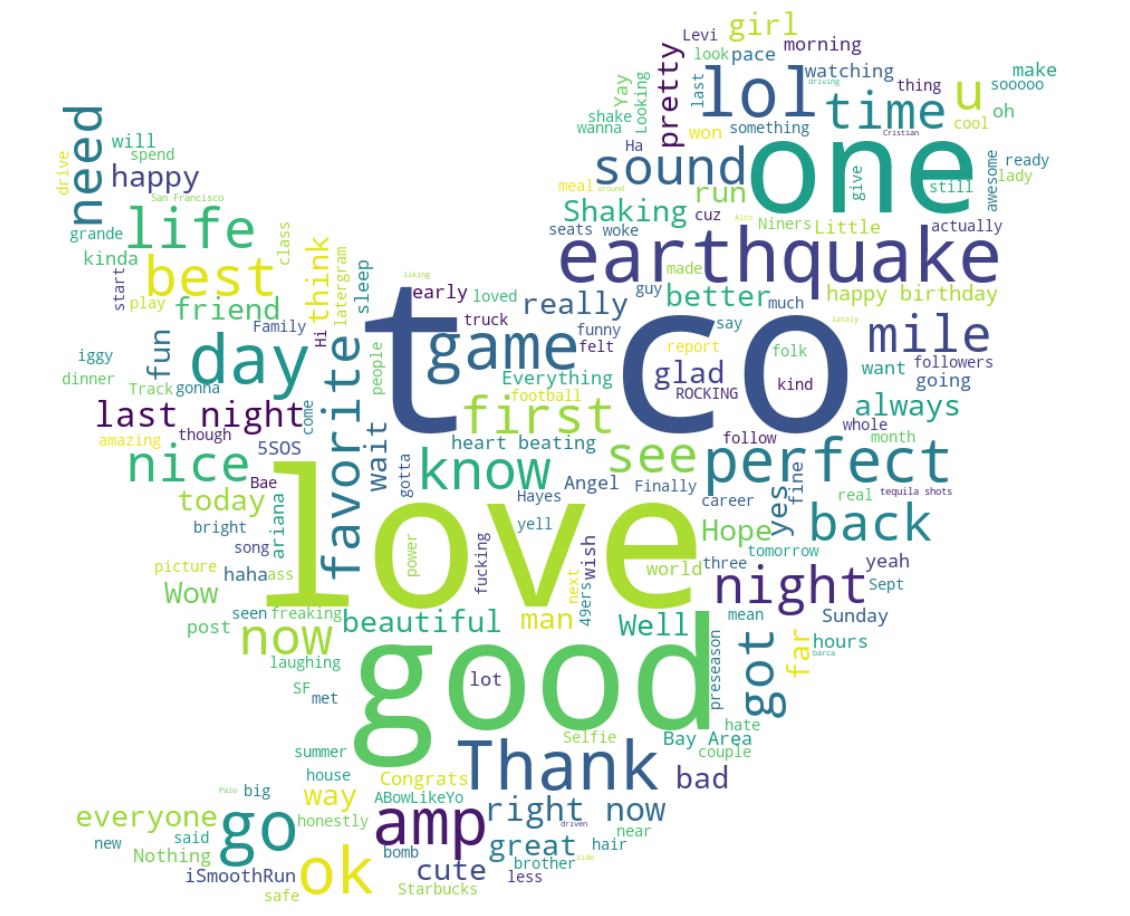

In [35]:
wordcloud = WordCloud(background_color='white',mask=mask).generate(' '.join(df_sent[df_sent.sentiment=='positive']['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Negative

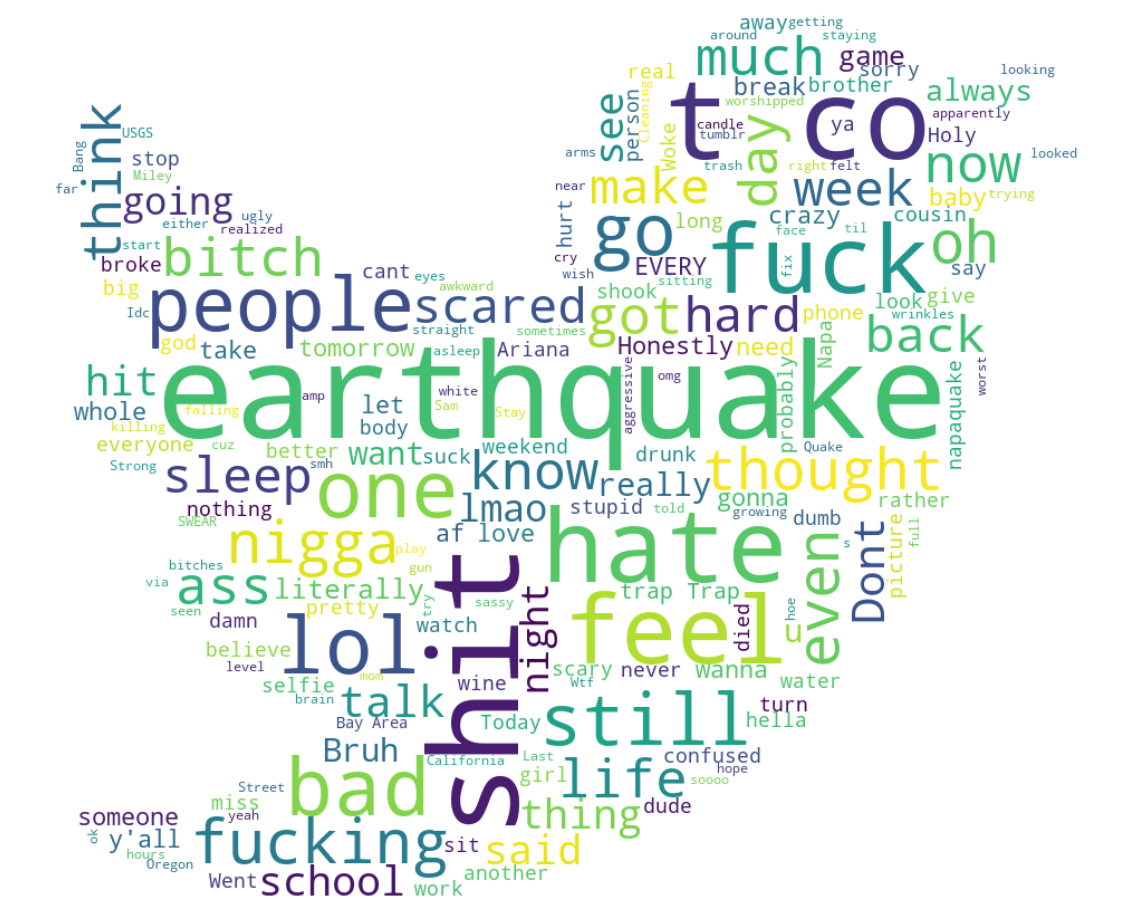

In [36]:
wordcloud = WordCloud(background_color='white',mask=mask).generate(' '.join(df_sent[df_sent.sentiment=='negative']['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Neutral

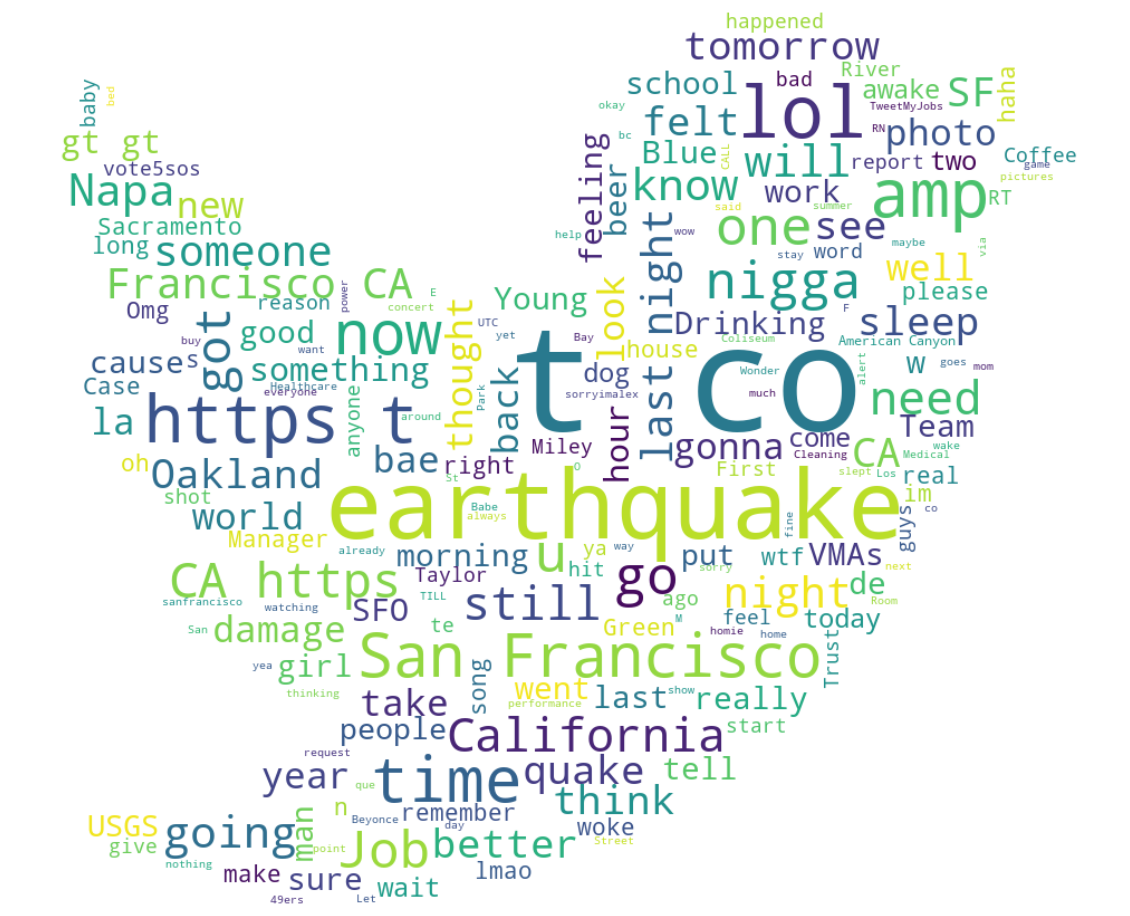

In [37]:
wordcloud = WordCloud(background_color='white',mask=mask).generate(' '.join(df_sent[df_sent.sentiment=='neutral']['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Compare sentiments across topics

### First topic

In [38]:
topic_number = 2

In [49]:
df_topic = df_sent.loc[df_sent['topics'] == topic_number]

print('Number of positive tweets: ', (len(df_topic[df_topic.sentiment == 'positive'])))
print('Number of negative tweets: ', (len(df_topic[df_topic.sentiment == 'negative'])))

KeyError: 'topics'

In [46]:
wordcloud = WordCloud(background_color='white',mask=mask).generate(' '.join(df_topic[df_topic.sentiment=='positive']['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Is there a difference in the density distributions with regards to the tweet sentiment?

In [47]:
sentiments = ['negative', 'positive']
base_maps = []

y = statistics.mean(df_sent['latitude']) 
x = statistics.mean(df_sent['longitude']) 

for sentiment in sentiments:
    df_sentiment = df_sent.loc[df_sent['sentiment'] == sentiment]
    base_map = generateBaseMap([y,x],8)
    HeatMap(data=df_sentiment[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
    base_maps.append(base_map)

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(base_maps[0].get_root().render().replace('"', '&quot;'),500,500,
                   base_maps[1].get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
